In [1]:
import logging
import time
import jax
import optax
import data
import dataclasses

import matplotlib.pyplot as plt
import functools as ft
import haiku as hk
import typing as t
import jax.numpy as jnp
import numpy as np

### statics

In [2]:
BLOCK_SIZE = int(24*5*60/5)
BATCH_SIZE = 2
SPLIT = 0.85
LEARNING_RATE = 1e-4
SEED = 2137
NUM_TRAINING_STEPS = 15000
EVAL_INTERVAL = 100
EMBEDDING_SIZE = 4

VOCAB_SIZE = 256
PAD_TOKEN = 0
GRAD_CLIP_VALUE = 1

NUM_LAYERS = 3
NUM_HEADS = 6  # Number of attention heads.
MODEL_SIZE = 128
KEY_SIZE = 32
DROPOUT_RATE = 0.05

### utils

In [3]:
class TrainingState(t.NamedTuple):
  """Container for the training state."""
  params: hk.Params
  opt_state: optax.OptState
  rng: jax.Array
  step: jax.Array

class Batch(t.NamedTuple):
    inputs: np.ndarray  # Integer tokens, shape [B, T]
    targets: np.ndarray  # Integer tokens, shape [B, T]

Metrics = t.MutableMapping[str, t.Any]

In [4]:
@jax.jit
def local_label_smoothing(arr: jnp.array, std: int = 2, mean: float = 0.7):
    # assert arr.shape[1] % EMBEDDING_SIZE == 0
    # [0, 0, 0, 1, 0, 0]
    #   into
    # [0, 0.05, 0.1, 0.7, 0.1, 0.05]
    il = jnp.argmax(arr) + 2*std
    arr = arr * mean
    _lin = jnp.arange(std) + 1
    coef  = (1 - mean) / 2 / _lin.sum()
    c = jnp.apply_along_axis(lambda x: jnp.convolve(jnp.array([.05, .1, .7, .1, .05]), x, mode="same"), -1, arr)
    return c

In [5]:
@jax.jit
def to_bytes(arr):
  """ Converts an array of uint32 into an array of bytes in little endian"""

  @ft.partial(jax.vmap, in_axes=(None, 0), out_axes=-1)
  def _to_bytes(arr, byte_index:int):
    mask = 0xFF << (8 * byte_index)
    b = (arr & mask) >> 8 * byte_index
    return  b.astype(jnp.uint8)

  return _to_bytes(arr, jnp.arange(4))

@ft.partial(jax.jit, static_argnames=("axis"))
def from_bytes(array, axis):
  """ Converts an array of bytes in little endian  into an array of uint32"""

  @ft.partial(jax.vmap, in_axes=(axis, -1))
  def _from_bytes(arr, byte_index):
    return arr << 8 * byte_index

  return jnp.sum(_from_bytes(array, jnp.arange(4)), axis=axis)

### load data

In [6]:
sdl = data.SimpleDataLoader("../data/samples_5m_subset_v1.csv",
                            BLOCK_SIZE,
                            BATCH_SIZE,
                            EMBEDDING_SIZE,
                            SPLIT,
                            normalize=False,
                            log=False,
                            shift=False,
                            batch_first=True
                            )
train_di = sdl.get_data_iter("train")
test_di = sdl.get_data_iter("test")

In [7]:
expl_batch = next(train_di)
expl_batch["target"].shape

(2, 1440)

In [8]:
expl_batch['input'][0, :4]

Array([877202, 764640, 846270, 898147], dtype=int32)

In [9]:
to_bytes(expl_batch['input']).reshape(BATCH_SIZE, BLOCK_SIZE*4)[0, :16]

Array([146,  98,  13,   0, 224, 170,  11,   0, 190, 233,  12,   0,  99,
       180,  13,   0], dtype=uint8)

In [10]:
to_bytes(expl_batch['input'])[0, :3, :]

Array([[146,  98,  13,   0],
       [224, 170,  11,   0],
       [190, 233,  12,   0]], dtype=uint8)

In [11]:
def preproc_data(batch: dict):
    _inputs = to_bytes(batch['input'])
    _targets = to_bytes(batch['target'])
    # TODO: make it a bit cleaner
    _inputs = _inputs.reshape((BATCH_SIZE, EMBEDDING_SIZE*BLOCK_SIZE))
    _targets = _targets.reshape((BATCH_SIZE, EMBEDDING_SIZE*BLOCK_SIZE))
    return Batch(inputs=_inputs, targets=_targets)

In [12]:
@jax.jit
def apply_byte_error_weights(arr: jnp.array):
    assert arr.shape[1] % EMBEDDING_SIZE == 0
    c = arr.shape[1] // EMBEDDING_SIZE
    weights = jnp.array([1., 2., 3., 4.] * c)
    return weights*arr

In [13]:
_inputs = preproc_data(expl_batch)
_inputs.inputs.shape

(2, 5760)

### model

from: https://github.com/deepmind/dm-haiku/tree/main/examples/transformer

In [14]:
"""Didactic exasmple of an autoregressive Transformer-based language model.
Glossary of shapes:
- B: Batch size.
- T: Sequence length.
- D: Model embedding size.
- H: Number of attention heads.
- V: Vocabulary size.
"""

def layer_norm(x: jax.Array) -> jax.Array:
  """Applies a unique LayerNorm to x with default settings."""
  ln = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)
  return ln(x)


@dataclasses.dataclass
class Transformer(hk.Module):
  """A transformer stack."""

  num_heads: int
  num_layers: int
  key_size: int
  dropout_rate: float
  widening_factor: int = 4
  name: t.Optional[str] = None

  def __call__(
      self,
      embeddings: jax.Array,  # [B, T, D]
      mask: jax.Array,  # [B, T]
      *,
      is_training: bool = True,
  ) -> jax.Array:  # [B, T, D]
    """Transforms input embedding sequences to output embedding sequences."""

    initializer = hk.initializers.VarianceScaling(2 / self.num_layers)
    dropout_rate = self.dropout_rate if is_training else 0.
    _, seq_len, model_size = embeddings.shape

    # Compute causal mask for autoregressive sequence modelling.
    mask = mask[:, None, None, :]  # [B, H=1, T'=1, T]
    causal_mask = np.tril(np.ones((1, 1, seq_len, seq_len)))  # [B=1, H=1, T, T]
    mask = mask * causal_mask  # [B, H=1, T, T]

    h = embeddings
    for _ in range(self.num_layers):
      # First the attention block.
      attn_block = hk.MultiHeadAttention(
          num_heads=self.num_heads,
          key_size=self.key_size,
          model_size=model_size,
          w_init=initializer,
      )
      h_norm = layer_norm(h)
#       h_attn = attn_block(h_norm, h_norm, h_norm, mask=mask)
      h_attn = attn_block(h_norm, h_norm, h_norm)
      h_attn = hk.dropout(hk.next_rng_key(), dropout_rate, h_attn)
      h = h + h_attn

      # Then the dense block.
      dense_block = hk.Sequential([
          hk.Linear(self.widening_factor * model_size, w_init=initializer),
          jax.nn.gelu,
          hk.Linear(model_size, w_init=initializer),
      ])
      h_norm = layer_norm(h)
      h_dense = dense_block(h_norm)
      h_dense = hk.dropout(hk.next_rng_key(), dropout_rate, h_dense)
      h = h + h_dense

    return layer_norm(h)


@dataclasses.dataclass
class TransformerModel(hk.Module):
  """An autoregressive transformer-based model."""

  transformer: Transformer
  model_size: int
  vocab_size: int
  pad_token: int
  name: t.Optional[str] = None

  def __call__(
      self,
      tokens: jax.Array,
      *,
      is_training: bool = True,
  ) -> jax.Array:
    """Forward pass, producing a sequence of logits."""
    input_mask = jnp.greater(tokens, self.pad_token)
    unused_batch_size, seq_len = tokens.shape

    # Embed the input tokens and positions.
    embed_init = hk.initializers.TruncatedNormal(stddev=0.02)
    token_embedding_map = hk.Embed(
        self.vocab_size, embed_dim=self.model_size, w_init=embed_init)
    token_embeddings = token_embedding_map(tokens)
    positional_embeddings = hk.get_parameter(
        'positional_embeddings', [seq_len, self.model_size], init=embed_init)
    input_embeddings = token_embeddings + positional_embeddings  # [B, T, D]

    # Run the transformer over the inputs.
    embeddings = self.transformer(
        input_embeddings,
        input_mask,
        is_training=is_training,
    )  # [B, T, D]

    # Decode the embeddings (here, we use untied weights).
    return hk.Linear(self.vocab_size)(embeddings)  # [B, T, V]

### training

In [15]:
def forward(tokens: t.Union[np.ndarray, jax.Array]) -> jax.Array:
    net = TransformerModel(
        model_size=MODEL_SIZE,
        vocab_size=VOCAB_SIZE,
        pad_token=PAD_TOKEN,
        transformer=Transformer(
            num_heads=NUM_HEADS,
            num_layers=NUM_LAYERS,
            key_size=KEY_SIZE,
            dropout_rate=DROPOUT_RATE,
        ),
    )
    return net(tokens)

# Create the optimiser.
def make_optimizer() -> optax.GradientTransformation:
    optimiser = optax.chain(
      optax.clip_by_global_norm(GRAD_CLIP_VALUE),
      optax.adam(LEARNING_RATE, b1=0.9, b2=0.99),
    )
    return optimiser

# Create the loss.
@hk.transform
def loss_fn(batch: Batch) -> jax.Array:
    """Computes the (scalar) loss on `data` w.r.t. params."""
    inp = batch.inputs[:, 3:]
    logits = forward(inp)
    
    targets = jax.nn.one_hot(batch.targets[:,  :-3], VOCAB_SIZE)  # (B, T*D, 256)
    # targets = local_label_smoothing(targets)
    assert logits.shape == targets.shape
    log_likelihood = jnp.sum(targets * jax.nn.log_softmax(logits, axis=-1), axis=-1)
#    log_likelihood = apply_byte_error_weights(log_likelihood)
    return -log_likelihood.mean()  # NLL per token.

@jax.jit
def update(state: TrainingState, batch) -> t.Tuple[TrainingState, Metrics]:
    """Does an SGD step and returns metrics."""
    rng, new_rng = jax.random.split(state.rng)
    loss_and_grad_fn = jax.value_and_grad(loss_fn.apply)
    loss, gradients = loss_and_grad_fn(state.params, rng, batch)

    optimiser = make_optimizer()
    updates, new_opt_state = optimiser.update(gradients, state.opt_state)
    new_params = optax.apply_updates(state.params, updates)

    new_state = TrainingState(
        params=new_params,
        opt_state=new_opt_state,
        rng=new_rng,
        step=state.step + 1,
    )

    metrics = {
        'step': state.step,
        'loss': loss,
    }
    return new_state, metrics

In [16]:
rng = jax.random.PRNGKey(SEED)
rng, init_rng = jax.random.split(rng)
init_batch = preproc_data(expl_batch)
initial_params = loss_fn.init(init_rng, init_batch)

initial_opt_state = make_optimizer().init(initial_params)
initial_state =  TrainingState(
    params=initial_params,
    opt_state=initial_opt_state,
    rng=rng,
    step=jnp.array(0),
)

In [17]:
prev_time = time.time()
state = initial_state
for step in range(NUM_TRAINING_STEPS):
    batch = preproc_data(next(train_di))
    state, metrics = update(state, batch)
    # We use JAX runahead to mask data preprocessing and JAX dispatch overheads.
    # Using values from state/metrics too often will block the runahead and can
    # cause these overheads to become more prominent.
    if step % EVAL_INTERVAL == 0:
      steps_per_sec = EVAL_INTERVAL / (time.time() - prev_time)
      prev_time = time.time()
      rng, new_rng = jax.random.split(rng)
      valid_loss = loss_fn.apply(state.params, new_rng, preproc_data(next(test_di))) 
      metrics.update({'steps_per_sec': steps_per_sec, 'valid_loss': valid_loss})
      print({k: float(v) for k, v in metrics.items()})

{'loss': 5.759206771850586, 'step': 0.0, 'steps_per_sec': 7.673625467242626, 'valid_loss': 5.146252155303955}
{'loss': 4.566343307495117, 'step': 100.0, 'steps_per_sec': 7.936330793475272, 'valid_loss': 4.398922920227051}
{'loss': 4.49170446395874, 'step': 200.0, 'steps_per_sec': 8.01583404259914, 'valid_loss': 3.288595676422119}
{'loss': 4.178997993469238, 'step': 300.0, 'steps_per_sec': 8.127671543400588, 'valid_loss': 3.3260915279388428}
{'loss': 3.1556215286254883, 'step': 400.0, 'steps_per_sec': 8.281527844964607, 'valid_loss': 3.2085752487182617}
{'loss': 3.7026379108428955, 'step': 500.0, 'steps_per_sec': 8.210676402249193, 'valid_loss': 3.6137075424194336}
{'loss': 3.8262696266174316, 'step': 600.0, 'steps_per_sec': 8.03250596538869, 'valid_loss': 4.120869159698486}
{'loss': 1.9641859531402588, 'step': 700.0, 'steps_per_sec': 7.990386931493933, 'valid_loss': 3.7649528980255127}
{'loss': 2.8108365535736084, 'step': 800.0, 'steps_per_sec': 8.007288739162211, 'valid_loss': 3.40084

KeyboardInterrupt: 

In [18]:
@hk.transform
def generate(context: jnp.array, rng) -> jnp.array:
    inp = context[:, 3:]
    logits = forward(inp)  # (B, T*D, 256)
    print(logits.shape)
    
    logits = jnp.concatenate((logits, jnp.zeros((BATCH_SIZE, 3, 256))), axis=1)
    logits = jax.random.categorical(rng, logits, axis=-1)
    res_bytes = logits.reshape((BATCH_SIZE, BLOCK_SIZE, EMBEDDING_SIZE))
    
    mask = jnp.array([1, 256, 256*256, 256*256*256])
    res = jnp.apply_along_axis(lambda x: jnp.sum(x*mask), -1, res_bytes)
    return res

In [19]:
test_batch = preproc_data(next(test_di))
rng = jax.random.PRNGKey(SEED+10)
rng, new_rng = jax.random.split(rng)
b = generate.apply(state.params, new_rng, test_batch.inputs, new_rng)

(2, 5757, 256)


In [20]:
b.shape, test_batch.targets.shape

((2, 1440), (2, 5760))

In [21]:
_dest = test_batch.targets.reshape((BATCH_SIZE, BLOCK_SIZE, EMBEDDING_SIZE))
mask = jnp.array([1, 256, 256*256, 256*256*256])
_dest = jnp.apply_along_axis(lambda x: jnp.sum(x*mask), -1, _dest)

In [22]:
print(f"MAE ... {jnp.mean(jnp.abs(_dest[:, :-1] - b[:, :-1]))}")

MAE ... 60627.671875


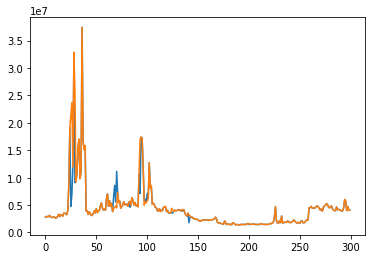

In [24]:
plt.figure()
plt.plot(b[0, :300])
plt.plot(_dest[0, :300])
plt.show()